<div class="alert alert-info" align = "center"> <h1> KCHOUSE - Machine Learning Models </h1> </div>

---
---
<a id="content_table"></a>
# <font color=red> Table of contents </font>

<b>[Part 1. Introduction](#introduction) </b><br>

<b>[Part 2. Setup](#setup)</b><br>

<b>[Part 3. Data Preparation](#data_preparation)</b><br>

<b>[Part 4. Decision Tree](#decision_tree)</b><br>

<b>[Part 5. Random Forest](#random_forest)</b><br>

<b>[Part 6. Gradient Boosting](#gradient_boosting)</b><br>

<b>[Part 7. XGBoost](#xgb)</b><br>

<b>[Part 8. DNN](#dnn)</b><br>

---
---
<a id="introduction"></a>
[content table](#content_table)

# <font color=red> 1. Introduction
    
This notebook uses the following ML models to predict house price:
1. Decision Trees
2. Random Forest
3. Gradient Boosting Trees
4. XGBoost
5. DNN

---
---
<a id="setup"></a>
[content table](#content_table)
# <font color=red> 2. Setup

### <font color=blue> 2.1. Configuration

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
from pathlib import Path
import os

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# project root
PROJECT_ROOT_PATH = os.path.abspath(os.path.join(os.pardir))
PROJECT_ROOT_DIR = Path(Path.cwd()).resolve().parent
# source code
FUNCTION_PATH = os.path.join(PROJECT_ROOT_DIR, "src")
# image path
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "image")
# data path
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
DATA_RAW = os.path.join(DATA_PATH, "raw")

sys.path.append(FUNCTION_PATH)

### <font color=blue> 2.2. Import library

In [2]:
# Dataframe manipulation
import numpy as np
import pandas as pd
import os

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# sns.set(style = 'whitegrid',context = 'notebook')
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Modelling Helpers:
from sklearn.preprocessing import Normalizer, scale
from sklearn import model_selection
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, ShuffleSplit, cross_validate

# statsmodels
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels as statm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import math
from math import sqrt

# Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,ElasticNet,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Evaluation metrics for Regression 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.svm import SVR
import xgboost as xgb

# other utilities
import joblib
import datetime

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")
# display various ranges 
pd.options.display.float_format = '{:.3f}'.format


Setup complete...


### <font color=blue> 2.3. Define utility function

In [121]:
# helper function for plotting residual plots
def plot_residual(ax1, ax2, ax3, ax4, y_pred, y_real, line_label, title):
    ax1.scatter(y_real, y_pred, color='blue',alpha=0.6,label=line_label)
    ax1.set_ylabel('Predicted Y') 
    ax1.set_xlabel('Real Y')
    ax1.legend(loc='best')
    ax1.set_title(title)

    ax2.scatter(y_pred,y_real - y_pred, color='green',marker='x',alpha=0.6,label='Residual')
    ax2.set_xlabel('Predicted Y')
    ax2.set_ylabel('Residual')    
    ax2.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')
    ax2.legend(loc='best')
    ax2.set_title('Residual Plot')
    
    ax3.hist(y_real - y_pred, bins=30, color='green', alpha=0.7)
    ax3.set_title('Histogram of residual values')
    
    stats.probplot(y_real - y_pred, plot=ax4)
    ax4.set_title('Q-Q plot of residual values')
    
    return ax1, ax2, ax3, ax4


def performance_evaluation(X_train, X_test, y_train, y_test, model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print('Train mse: {}'.format(mean_squared_error(y_train, pred_train)))
    print('Train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
    print()
    print('Test mse: {}'.format(mean_squared_error(y_test, pred_test)))
    print('Test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

---
---
<a id="data_preparation"></a>
[content table](#content_table)
# <font color=red> 3. Data Preparation

### <font color=blue> 3.1. Load data

In [4]:
data_file = "../data/raw/kc_house_data.csv"
df = pd.read_csv(data_file)
print(df.shape)
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,...,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650
1,6414100192,20141209T000000,538000.000,3,2.250,2570,7242,2.000,0,0,...,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,5631500400,20150225T000000,180000.000,2,1.000,770,10000,1.000,0,0,...,6,770,0,1933,0,98028,47.738,-122.233,2720,8062
3,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,...,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000
4,1954400510,20150218T000000,510000.000,3,2.000,1680,8080,1.000,0,0,...,8,1680,0,1987,0,98074,47.617,-122.045,1800,7503


## <font color=blue> 3.2. Data Processing - Define functions
    
This section is to perform data preprocessing which are identified after exploratory data analysis step. Instead of just doing this manually, it is more useful to create functions, for several good reasons:

+ This allows to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset)

+ Gradually build a libray of transformation functions that can be reused in future projects

+ Use these functions in live system to transform the new data before feeding it to your algorithms

+ This will make it possible to easily try various transformations and see which combination of transformations works best

For this dataset, these tasks will be performed for data preprocessing (refer notebook Data Exploratory Analysis for explanation):
1. Numeric data:
    + generate new var: sqft_ratio = sqft_living/sqft_living15
2. Categorical data:
    + Encode cat vars by calculating class ratio: ['zipcode']
    + Encode cat vars by creating dummy vars ['season']
3. temporal vars:
    + convert obj var to date time var: date
    + generate new var: season                                     
4. Handling missing data:
    + numeric data
    + categorical var
5. Scaling num var
                                   

### Define variables

In [118]:
features = ['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
            'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
            'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

target = 'price'

all_vars = features + [target]
print(all_vars)

# rename columns
FEATURE_MAP = {'date': 'date',
                'price': 'price'}

# data type conversion
DATA_TYPE = {'zipcode': 'str',
             'date': 'object',
             'price': 'float64',
             'bedrooms': 'int64',
             'bathrooms': 'int64',
             'sqft_living': 'int64',
             'sqft_lot': 'int64',
             'floors': 'int64',
             'waterfront': 'int64',
             'view': 'int64',
             'condition': 'int64',
             'grade': 'int64',
             'sqft_above': 'int64',
             'sqft_basement': 'int64',
             'yr_built': 'int64',
             'yr_renovated': 'int64',
             'lat': 'float64',
             'long': 'float64',
             'sqft_living15': 'int64',
             'sqft_lot15': 'int64'}

TARGET = 'price'
TEMPORAL_VARS = ['year']
TEXT_VARS = []
NUMERICAL_VARS = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                  'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
                  'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 
                  'sqft_living15', 'sqft_lot15']
CATEGORICAL_VARS = ['season']
TRAIN_NUMERICAL_VARS = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                  'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
                  'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 
                  'sqft_living15', 'sqft_lot15', 'sqft_ratio', 'zipcode']

# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = []
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA = []
# variables to log transform
NUMERICALS_LOG_VARS = []

['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']


### Data file from processing step

In [119]:
dummy_path = os.path.join('kchouse_train_dummy.npy')
ordinal_label_path = os.path.join('kchouse_OrdinalLabels.npy')
scaler_path = os.path.join('kchouse_scaler.pkl')

### Cleasing data

In [120]:
def clean_data(df):
    
    data = df.copy()
    
    # Rename columns
    data.rename(columns=FEATURE_MAP, inplace=True)
    
    # data type conversion
    for key in DATA_TYPE:
        data[key] = data[key].astype(DATA_TYPE[key])
    
    # Remove duplicated data
    data = data.drop_duplicates(keep = 'last')
    
    # Reset index
    data = data.reset_index(drop = True)
    
    return data

### Data processing and transforming

In [153]:
def generate_season(df, date):
    
    data = df.copy()
    data[date] = pd.to_datetime(data[date])
    data['month'] = data[date].apply(lambda x:x.month)
    data['year'] = data[date].apply(lambda x:x.year)
    data['season'] = 'N/A'
    data.loc[data.month.isin([12,1,2]), 'season'] = 'winter'
    data.loc[data.month.isin([3,4,5]), 'season'] = 'spring'
    data.loc[data.month.isin([6,7,8]), 'season'] = 'summer'
    data.loc[data.month.isin([9,10, 11]), 'season'] = 'autum'
    
    return data


def sqft_ratio(df, var1, var2):
    
    data = df.copy()
    
    data['sqft_ratio'] = data[var1]/data[var2]
    
    return data


def replace_categories(train, var, target):
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
    return ordinal_label 


def encode_categorical(df, var_list, target, train_flag=0):
    
    data = df.copy()

    if(train_flag == 1):
        ordinal_label_dict = {}
        for var in var_list:
            ordinal_label = replace_categories(data, var, target)
            ordinal_label_dict[var] = ordinal_label
        # now we save the dictionary
        np.save(ordinal_label_path, ordinal_label_dict)
    else:
        ordinal_label_dict = np.load(ordinal_label_path, allow_pickle=True).item()
        
    for var in var_list:
        ordinal_label = ordinal_label_dict[var]
        data[var] = data[var].map(ordinal_label)
    
    return data


def create_dummy_vars(df, var_list, train_flag=0):  
    
    data = df.copy()
    data_categorical = pd.DataFrame()
    for var in var_list:
        data_dummies = pd.get_dummies(data[var], prefix=var, prefix_sep='_',drop_first=True)  
        data_categorical = pd.concat([data_categorical, data_dummies], axis=1)    
    
    if(train_flag == 1):
        train_dummy = list(data_categorical.columns)
        pd.Series(train_dummy).to_csv(dummy_path, index=False)
    else:
        test_dummy = list(data_categorical.columns)
        train_dummy = pd.read_csv(dummy_path)
        train_dummy.columns = ['Name']
        train_dummy = list(train_dummy.Name.values)   
        
    for col in train_dummy:
        if col not in data_categorical:
            data_categorical[col] = 0
    
    return data_categorical


def scaling_data(df, var_list, train_flag=0):
    
    data = df.copy()
   
    # fit scaler
    scaler = MinMaxScaler() # create an instance
    scaler.fit(data[var_list]) #  fit  the scaler to the train set for later use
    
    # we persist the model for future use
    if(train_flag == 1):
        joblib.dump(scaler, scaler_path)
    scaler = joblib.load(scaler_path)  
    
    data = pd.DataFrame(scaler.transform(data[var_list]), columns=var_list)
    
    return data

### Data Pipeline

In [154]:
def data_engineering_pipeline(df, train_flag=0):

    print('train_flag:', train_flag)
     
    df = clean_data(df)
    df = generate_season(df, 'date')
    df = sqft_ratio(df, 'sqft_living', 'sqft_living15')
    df = encode_categorical(df, ['zipcode'], TARGET, train_flag)
    data_categorical = create_dummy_vars(df, ['season'], train_flag)
    data_scale = scaling_data(df, TRAIN_NUMERICAL_VARS, train_flag)
    
    df = pd.concat([data_scale,data_categorical], axis=1)

    return df

## <font color=blue> 3.3. Data Processing - Apply to Train set and Test set

In [155]:
# split data
X_train, X_test, y_train, y_test = train_test_split(df, df[TARGET], test_size=0.2, random_state=0)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

new_obj = pd.DataFrame(X_test.iloc[0]).T
processed_X_train = data_engineering_pipeline(X_train, train_flag=1)
processed_X_test = data_engineering_pipeline(X_test)
TRAIN_VARS = list(processed_X_train.columns)
print(TRAIN_VARS)

X_train = processed_X_train[TRAIN_VARS]
X_test = processed_X_test[TRAIN_VARS]

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

df_train.head()

train_flag: 1
train_flag: 0
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_ratio', 'zipcode', 'season_spring', 'season_summer', 'season_winter']


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,sqft_ratio,zipcode,season_spring,season_summer,season_winter,price
0,0.091,0.125,0.097,0.003,0.000,0.000,0.000,0.750,0.500,0.086,...,0.866,0.163,0.240,0.007,0.122,0.710,0,0,1,495000.000
1,0.091,0.250,0.112,0.006,0.000,0.000,0.000,0.750,0.583,0.101,...,0.646,0.304,0.335,0.010,0.102,0.899,0,1,0,635000.000
2,0.091,0.125,0.060,0.006,0.000,0.000,0.000,0.500,0.583,0.088,...,0.756,0.399,0.230,0.011,0.079,0.812,1,0,0,382500.000
3,0.121,0.250,0.145,0.004,0.500,0.000,0.000,0.500,0.583,0.211,...,0.426,0.276,0.275,0.007,0.162,0.130,0,1,0,382500.000
4,0.091,0.250,0.114,0.003,0.500,0.000,0.000,0.500,0.500,0.104,...,0.788,0.127,0.244,0.005,0.142,0.884,0,0,0,670000.000


---
---
<a id="decision_tree"></a>
[content table](#content_table)
# <font color=red> 4. Decision Tree
    
### <font color=blue>4.1. Overview
1. **Idea**: Decision tree is a non-parametric model which involves stratifying or segmenting the predictor space into a number of simple regions using splitting rules based on possible values of features. The set of splitting rules used to segment the object space can usually be summarized in a tree, so these are decision tree methods  
    
2. **Example**: 
    + ***Data***: We use the Hitters data set to predict a baseball player’s Salary based on Years (the number of years that he has played in the major leagues) and Hits (the number of hits that he made in the previous year). log-transform Salary is applied so that its distribution has more of a typical bell-shape
    + **Spliting rules/Decision Tree**: A regression tree fit to this data; represents estimate f^ of the true f. it consists of a series of splitting rules, starting at the top of the tree
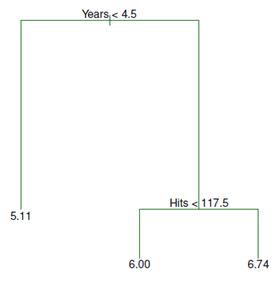
    + ***Regions***: Overall, the tree stratifies the players into three regions of object space: 
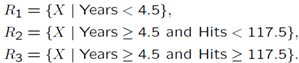
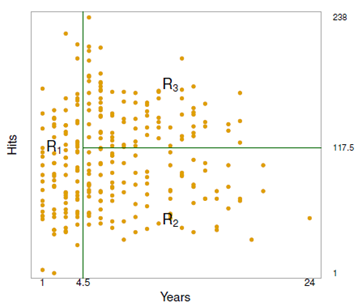

3. **CART Algorithm**: For regression problem, the CART tries to construct the predictor space into J distinct and non-overlapping regions R1, R2,.,Rj that minimizes the residual sum of squares (RSS):
    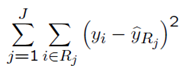
    
    + ***Node splitting***: It is top-down, greedy manner approach. The basic process tries to split data points using different attributes/features and test against a cost function. It first selects the attribute Xj and the cutpoint value s such that the splitting the object space into 2 regions R1 (j,s) = {X | Xj < s} and R2 (j,s) = {X | Xj >= s} leads to the greatest possible reduction in RSS (means we seek the values of j and s that minimize):
    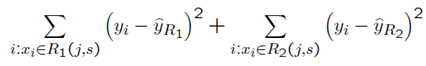
    (where y^R1 is the mean label for the training observations in R1(j,s) and y^R2 is the mean label for the training observations in R2(j,s))
    + ***Iteration***: Next, it continues looking for the best attribute and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions. However, this time, instead of splitting the entire object space, it splits one of the two previously identified regions. Now there are three regions. Again, it look to split one of these three regions further, so as to minimize the RSS. The process continues until a stopping criterion is reached such as no region contains more than five observation belongs
    + ***Prediction***: For every observation that falls into the region Rj, it make the same prediction, which is simply the mean of the label values for the training observations in Rj

### <font color=blue>4.2. Train model with default hyper-parameters
    
**There is no contrainsts for hyper-parameters**

In [156]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
tree_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

#### Model Performance

In [157]:
train_score = tree_model.score(X_train, y_train)
test_score = tree_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9999
Test R-squared: 0.7726


=> It is obviously that overfitting in the training set very badly, the model produces perfectly predict on train test (Train R-squared = 0.9999), while it predicted much poorer on the test set (R-squared = 0.77)

=> Without any regularization (i.e., using the default hyper-parameters), Decision trees often suffers overfitting problem. This is because the tree might be too complicated and goes too deep and thus to fit details of the particluar data rather than the overall properties of the distribution they are drawn from. Thus, it is necessary to tune the model to find the best combination of hyperparameters

### <font color=blue> 4.3. Tuning hyper-parameters

1. **Hyper-parameters**: Hyperparameters are the knobs and controls we set with an aim to optimize the model’s performance on unseen data. These hyperparameters are different from parameters which are learned by our learning algorithm over the course of training process. Hyperparameters help us achieve objectives of avoiding overfitting and so on. Decision trees provide us with quite a few hyperparameters to play with 
    + min_samples_split: the minimum number of samples a node must have before it can be split
    + min_samples_leaf: the minimum number of samples a leaf node must have
    + min_weight_fraction_leaf: same as min_samples_leaf but expressed as a fraction of the total number of weighted instances
    + max_leaf_nodes: maximum number of leaf nodes
    + max_features: maximum number of features that are evaluated for splitting at each node
    + increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model

    
2. **Grid search**: The actual training process for decistion tree involves using k-fold cross validation to tune hyperparameters. Grid search is one of the popular methods for this task. It is a systematic approach where all combinations of parameters are tried to find the best combination. It is important to understand that grid search with cross validation was optimizing on finding the best set of hyperparmeters that can  help prepare a generalizable Decision Tree Regressor. 
    + Hyper-parameters are defined using a dictionary. The dictionary basically provides a list of feasible values for each of the hyperparmeters that we want to fine-tune.
    + sklearn provides a utility to grid search of the hyperparameters  with k-fold cross validation is an iterative process wrapped, optimized and standardized by GridSearchCV() function from model_selection module

#### Performing Grid search

In [158]:
from sklearn.model_selection import GridSearchCV

# create a dictionary to define hyper-parameters and their possible values
param_grid = {
    'criterion': ['mse'],
    'min_samples_split':  [50, 100],
    'min_samples_leaf': [30, 60],
    'max_depth': [6, 8],
}

# create a base model
tree_model = DecisionTreeRegressor()
# Instantiate the grid search model
tree_grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=10, n_jobs=-1)
# Fit the grid search to the train data
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [6, 8],
                         'min_samples_leaf': [30, 60],
                         'min_samples_split': [50, 100]})

#### View the hyperparameters and detailed information for the model

In [159]:
# view best score
print('R-Squared: {}'.format(tree_grid_search.best_score_))

# view best hyperparameters
print('Best hyperparameters: {}'.format(tree_grid_search.best_params_))

# view detailed information of search iteration of GridSearchCV
gridsearch_df = pd.DataFrame(tree_grid_search.cv_results_)
gridsearch_df.head()

R-Squared: 0.7802641197961536
Best hyperparameters: {'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 30, 'min_samples_split': 50}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.343,0.029,0.010,0.003,mse,6,30,50,"{'criterion': 'mse', 'max_depth': 6, 'min_samp...",0.774,...,0.757,0.742,0.762,0.738,0.801,0.750,0.762,0.759,0.019,3
1,0.346,0.035,0.009,0.003,mse,6,30,100,"{'criterion': 'mse', 'max_depth': 6, 'min_samp...",0.774,...,0.753,0.737,0.755,0.730,0.801,0.757,0.759,0.757,0.021,4
2,0.365,0.033,0.008,0.002,mse,6,60,50,"{'criterion': 'mse', 'max_depth': 6, 'min_samp...",0.761,...,0.743,0.699,0.747,0.750,0.777,0.762,0.708,0.739,0.030,7
3,0.311,0.038,0.009,0.006,mse,6,60,100,"{'criterion': 'mse', 'max_depth': 6, 'min_samp...",0.761,...,0.743,0.699,0.747,0.750,0.777,0.762,0.708,0.739,0.030,7
4,0.439,0.066,0.012,0.008,mse,8,30,50,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.794,...,0.791,0.755,0.778,0.771,0.820,0.765,0.789,0.780,0.020,1


#### Train model with the best paramters

In [160]:
tree_model = tree_grid_search.best_estimator_
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=30, min_samples_split=50)

### <font color=blue>  4.4. Prediction

In [161]:
pred_train = tree_model.predict(X_train)
print('Train prediction: ', list(pred_train[0:5]))
print('Train true label: ', list(y_train[0:5]))
print()
pred_test = tree_model.predict(X_test)
print('Test prediction: ', list(pred_test[0:5]))
print('Test true label: ', list(y_test[0:5]))
print()
print('Average house price: ',  y_train.median())

Train prediction:  [602322.2541436465, 528574.8974358974, 411141.6152671756, 327469.37581274385, 477841.32516703784]
Train true label:  [495000.0, 635000.0, 382500.0, 382500.0, 670000.0]

Test prediction:  [374022.1590909091, 1704484.6666666667, 478474.7464285714, 487063.63157894736, 649652.7666666667]
Test true label:  [297000.0, 1578000.0, 562100.0, 631500.0, 780000.0]

Average house price:  453000.0


### <font color=blue>  4.5. Model Evaluation

#### R-squared

In [162]:
train_score = tree_model.score(X_train, y_train)
test_score = tree_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.8133
Test R-squared: 0.7977


=> With the best hyper-parameters, the decision trees is now more generalized, leading the performance on both train set and test set are quite similar

#### MSE and RMSE

In [163]:
print('linear train mse: {}'.format(mean_squared_error(y_train, pred_train)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print()
print('linear test mse: {}'.format(mean_squared_error(y_test, pred_test)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

linear train mse: 25895548846.564045
linear train rmse: 160920.9397392522

linear test mse: 24056762737.804733
linear test rmse: 155102.42660192243


#### Residual plot

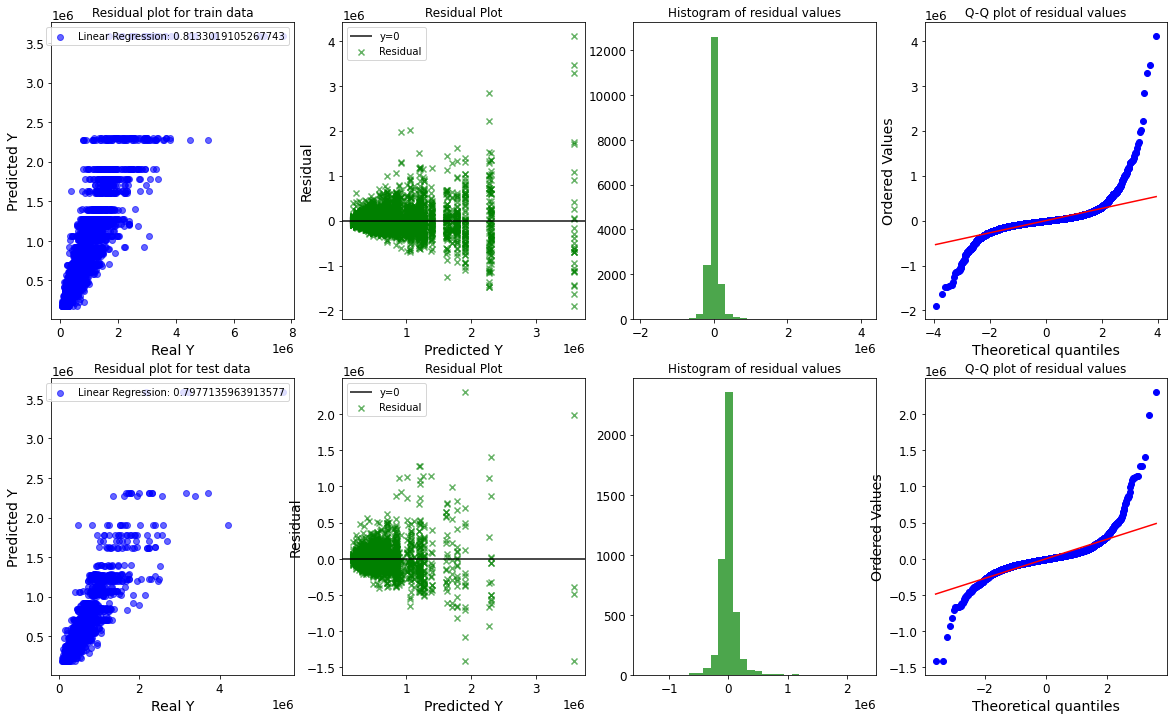

In [164]:
fig, axes = plt.subplots(2,4,figsize=(20,12))
plot_residual(axes[0][0],axes[0][1],axes[0][2],axes[0][3],pred_train,y_train,'Linear Regression: {}'.format(train_score),'Residual plot for train data')
plot_residual(axes[1][0],axes[1][1],axes[1][2],axes[1][3],pred_test,y_test,'Linear Regression: {}'.format(test_score),'Residual plot for test data')
fig.show()

#### Cross validation

In [165]:
# Cross validation
cv_scores = cross_val_score(tree_model, X_train, y_train, scoring='r2', cv=10)
rmse = np.sqrt(-cross_val_score(tree_model, X_train, y_train, scoring='neg_mean_squared_error'))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ', np.round(np.mean(rmse), 2))

R2 score:  [0.79383267 0.74719523 0.79233028 0.79078238 0.75523773 0.77802772
 0.77094035 0.82044922 0.76524835 0.78859727]
Average R2 score:  0.78
Average RMSE score:  181114.95


### <font color=blue>  4.5. Visualize the tree

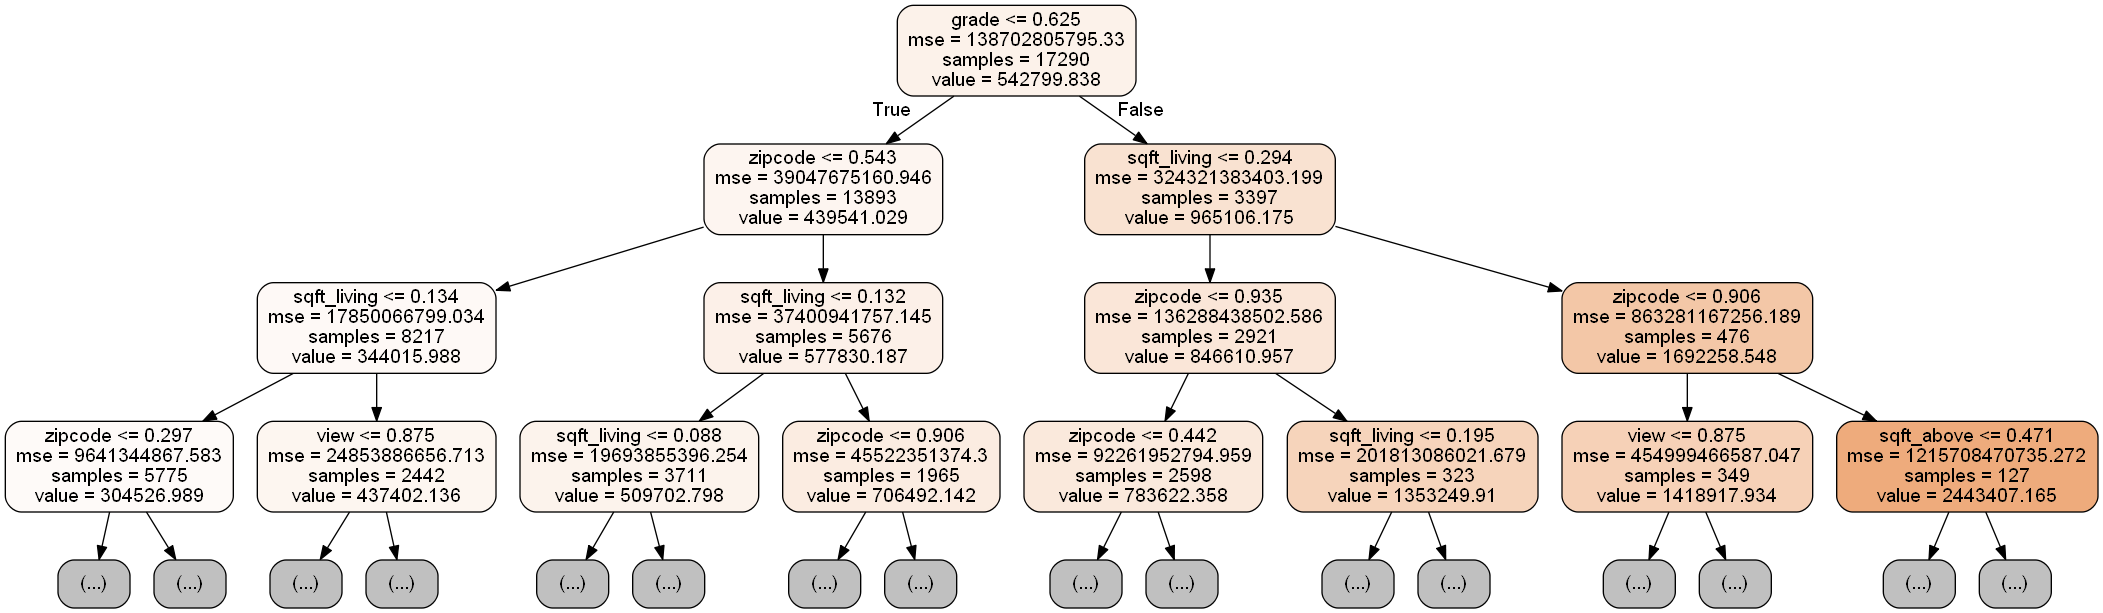

In [35]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import Image

export_graphviz(
    tree_model,
    out_file='kchouse_tree.dot',
    #out_file=None,
    feature_names = TRAIN_VARS,
    class_names = TARGET,
    special_characters=False,
    rounded=True,
    filled=True,
    max_depth=3
)

! dot -Tpng kchouse_tree.dot -o kchouse_tree.png
Image('kchouse_tree.png')

### <font color=blue>  4.6. Interpretation
    
The plot shows the root node being split on attribute `grade` and then going on until it reached a stopping criteria. This plot display nodes with depth from 1 to 3, however, the tree actually goes deeper to depth of 8 (best chosen hyperparameter).
    
The top split assigns observation having grade <= 0.625 to the left branch. The predicted price for these houses is given by the mean value of prices in the dataset with grade  <= 0.625 which is around 439,541 usd. Houses with grades > 0.625 are assigned to the right branch with the predicted price of 965,000 usd. Then these groups are further subdivided by sqft_living and zipcode

`grade` is the most important factor in determining house price, houses having grade below this grade are likely old houses and therefore have lower price. Given that houses have the same grade, `zipcode` which represents the residential region (higher zipcode value means more expensive regions since zipcode values were derived from average prices of the houses in a particular zipcode) or `sqft_living` which represents the area are used to determine the house price. 

### <font color=blue>  4.8. Feature Importance

In [36]:
# Get numerical feature importance
feature_importance = list(tree_model.feature_importances_)
feature_labels = TRAIN_VARS
# List of tuples with variable and importance
feature_importance_list = [(feature, round(importance, 2)) for feature, importance in zip(feature_labels, feature_importance)]
# Sort the featue importance by most important first
feature_importance_list = sorted(feature_importance_list, key=lambda x:x[1], reverse=True)
# Print out the feature and importance
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importance_list];

grade                Importance: 0.4
zipcode              Importance: 0.26
sqft_living          Importance: 0.23
view                 Importance: 0.05
sqft_above           Importance: 0.03
lat                  Importance: 0.01
long                 Importance: 0.01
sqft_living15        Importance: 0.01
bedrooms             Importance: 0.0
bathrooms            Importance: 0.0
sqft_lot             Importance: 0.0
floors               Importance: 0.0
waterfront           Importance: 0.0
condition            Importance: 0.0
sqft_basement        Importance: 0.0
yr_built             Importance: 0.0
yr_renovated         Importance: 0.0
sqft_lot15           Importance: 0.0
sqft_ratio           Importance: 0.0
season_spring        Importance: 0.0
season_summer        Importance: 0.0
season_winter        Importance: 0.0


Text(0.5, 1.0, 'Variable Importances')

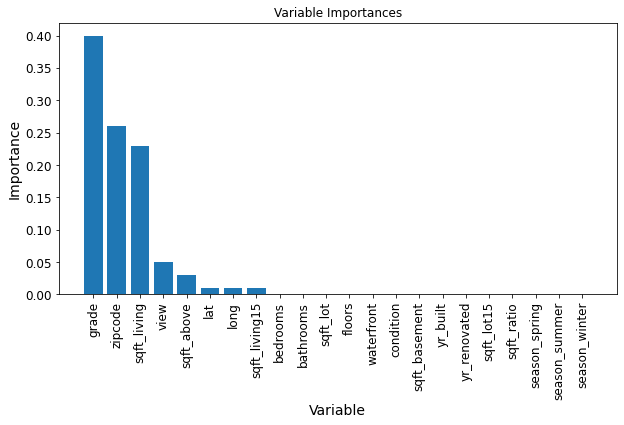

In [37]:
plt.figure(figsize=(10,5))
# list of x locations for plotting
feature_labels = [pair[0] for pair in feature_importance_list]
x_values = list(range(len(feature_labels)))
y_values = [pair[1] for pair in feature_importance_list]
# Make a bar chart
plt.bar(x_values, y_values, orientation='vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_labels, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

Text(0.5, 1.0, 'Feature Importance')

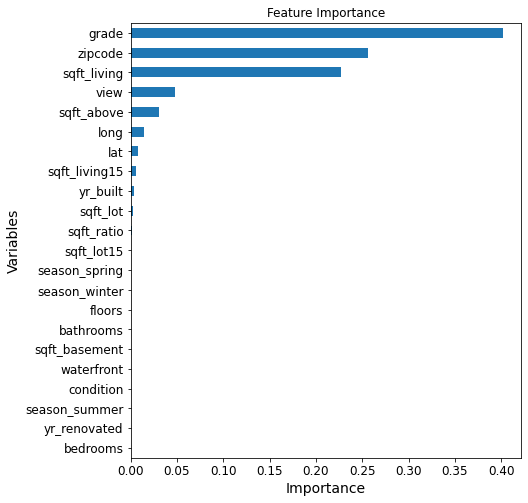

In [38]:
feature_importance = pd.Series(tree_model.feature_importances_)
feature_importance.index = TRAIN_VARS
feature_importance.sort_values(inplace=True, ascending=True)
feature_importance.plot.barh(figsize=(7,8))
plt.ylabel('Variables')
plt.xlabel('Importance')
plt.title('Feature Importance')

The main issue with Decision Trees is that they are very sensitive to small variations in the training data. This results in decision trees can be unstable because small variations in the data might result in a completely different tree being generated: generating the optimal tree is NP-complete: heuristic solutions are used (greedy approach). Therefore, while they are computationally cheap for prediction, training the decision tree can be computationally expensive.


---
---
<a id="random_forest"></a>
[content table](#content_table)
# <font color=red>5. Random Forest
    
### <font color=blue>5.1. Overview
    
1. **Idea**: Random forests are an example of an ensemble method, meaning that it combine multiple machine learning algorithms and use the aggregation predictions to obtain better predictive performance. Random forest supports sample both data and features. More specifically, the Random Forest algorithm introduces extra randomness when growing trees instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model.
    
    
2. **Algorithm**: 
    + ***Sampling dataset***: We use bootstrap technique to generate different bootstrapped training sets (select data from the original dataset with replacement)
    + ***Build a Decision Tree with each new sample***: But when building these decision trees, each time a split in a tree is considered, choose a random sample of m attributes as split candidates from the full set of p attributes (The split is allowed to use only one of those m attributes). A fresh sample of m attributes is taken at each split. The number of predictors considered at each split is approximately equal to the square root of the total number of predictors (m ≈ sqrt(p))
    + ***Prediction***: Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors which is the average for regression

### <font color=blue>5.2. Train model with default parameters

In [40]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# default parameters
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [41]:
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9838
Test R-squared: 0.8945


### <font color=blue> 5.3. Tuning model
    
Random Forest has all the parameters of a Decision Tree (to control how trees are grown), plus all the hyperparameter of a Bagging Classifier (to control the ensemble)

#### Setting values of hyperparameters for searching 

In [42]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    # 'bootstrap': [True],
    'max_depth': [8, 10],
    'max_features': [8, 12],
    'min_samples_leaf': [30, 50],
    'min_samples_split': [100],
    'n_estimators': [300]
}
# Create a based model
rf_model = RandomForestRegressor()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2) 
# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)  

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.7min finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 10], 'max_features': [8, 12],
                         'min_samples_leaf': [30, 50],
                         'min_samples_split': [100], 'n_estimators': [300]},
             verbose=2)

#### View the hyperparameters and detailed information for the model

In [43]:
# view best score
print('R-Squared:{}'.format(rf_grid_search.best_score_))
# View best hyperparameters
print('Best hyperparameters:{}'.format(rf_grid_search.best_params_))
# View detailed information of each iteration of GridSearchCV()
gridsearch_df = pd.DataFrame(rf_grid_search.cv_results_)
gridsearch_df.head(5)

R-Squared:0.8139715015006266
Best hyperparameters:{'max_depth': 10, 'max_features': 12, 'min_samples_leaf': 30, 'min_samples_split': 100, 'n_estimators': 300}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,24.734,1.846,0.202,0.020,8,8,30,100,300,"{'max_depth': 8, 'max_features': 8, 'min_sampl...",...,0.820,0.798,0.794,0.817,0.848,0.821,0.819,0.808,0.028,4
1,24.139,2.123,0.181,0.018,8,8,50,100,300,"{'max_depth': 8, 'max_features': 8, 'min_sampl...",...,0.814,0.783,0.778,0.801,0.833,0.812,0.805,0.795,0.028,8
2,35.496,2.835,0.179,0.027,8,12,30,100,300,"{'max_depth': 8, 'max_features': 12, 'min_samp...",...,0.818,0.795,0.800,0.816,0.849,0.825,0.822,0.810,0.027,2
3,35.190,3.115,0.188,0.044,8,12,50,100,300,"{'max_depth': 8, 'max_features': 12, 'min_samp...",...,0.813,0.785,0.784,0.804,0.837,0.818,0.807,0.799,0.028,6
4,26.862,1.568,0.234,0.062,10,8,30,100,300,"{'max_depth': 10, 'max_features': 8, 'min_samp...",...,0.822,0.799,0.798,0.817,0.849,0.822,0.825,0.810,0.028,3


It is important to understand that grid search with cross validation was optimizing on finding the best set of hyperparmeters that can  help prepare a generalizable Decision Tree Regressor. 

#### Train model with the best paramters

In [44]:
rf_model = rf_grid_search.best_estimator_
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=12, min_samples_leaf=30,
                      min_samples_split=100, n_estimators=300)

### <font color=blue> 5.4. Prediction

In [45]:
pred_train = rf_model.predict(X_train)
print('Train prediction: ',list(pred_train[0:5]))
print('Train true label: ',list(y_train[0:5]))
print()
pred_test = rf_model.predict(X_test)
print('Test prediction: ',list(pred_test[0:5]))
print('Test true label: ',list(y_test[0:5]))
print()
print('Average house price: ', y_train.median())

Train prediction:  [538952.1576830086, 573379.2465105167, 405022.2536488757, 330960.0770106635, 618630.5869458558]
Train true label:  [495000.0, 635000.0, 382500.0, 382500.0, 670000.0]

Test prediction:  [355941.4888350305, 1441276.9111590555, 529319.3734749778, 570091.0665309255, 749776.3726226367]
Test true label:  [297000.0, 1578000.0, 562100.0, 631500.0, 780000.0]

Average house price:  453000.0


### <font color=blue> 5.5. Model Evaluation

#### R-squared

In [46]:
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.8329
Test R-squared: 0.8350


#### MSE, RMSE

In [47]:
print('linear train mse: {}'.format(mean_squared_error(y_train, pred_train)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print()
print('linear test mse: {}'.format(mean_squared_error(y_test,pred_test)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

linear train mse: 23178706098.524273
linear train rmse: 152245.54541438734

linear test mse: 19620509038.605618
linear test rmse: 140073.2274155401


#### Residual plot

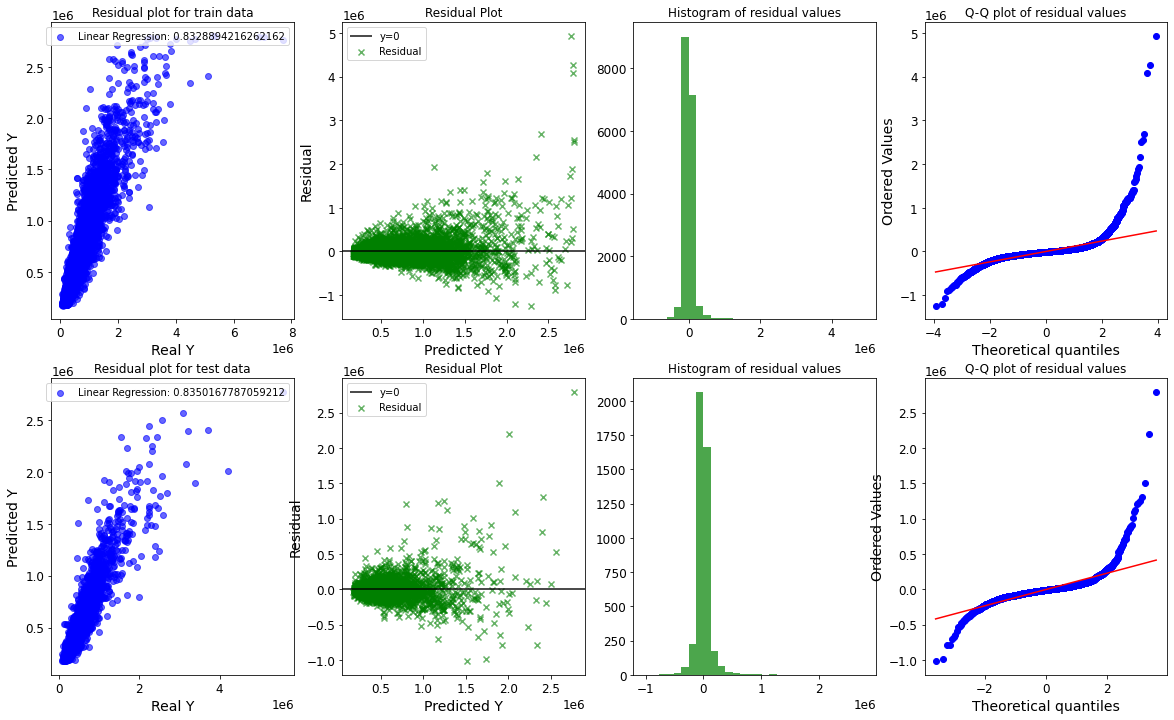

In [48]:
fig, axes = plt.subplots(2,4,figsize=(20,12))
plot_residual(axes[0][0],axes[0][1],axes[0][2],axes[0][3],pred_train,y_train,'Linear Regression: {}'.format(train_score),'Residual plot for train data')
plot_residual(axes[1][0],axes[1][1],axes[1][2],axes[1][3],pred_test,y_test,'Linear Regression: {}'.format(test_score),'Residual plot for test data')
fig.show()

### <font color=blue> 5.6. Feature Importance 
    
+ It can be difficult to interpret the resulting model. When we bag a large number of trees, it is no longer possible to represent the resulting statistical learning procedure using a single tree, and it is no longer clear which variables are most important to the procedure. Thus bagging improves prediction accuracy at the expense of interpretability.

+ Although the collection of bagged trees is much more difficult to interpret than a single tree, one can obtain an overall summary of the importance of each predictor using the RSS (for bagging regresssion trees) or the Gini index (for bagging classification trees). In the case of bagging regression trees, we can record the total amount that the RSS is decreased due to splits over a given predictor, averaged over all B trees. A large value indicates an important predictor. Similarly, in the context of bagging classification trees, we can add up the total amount that the Gini index is decreased by splits over a given predictor, average over all B trees.
    
+ For this dataset, it can be seen the mean decrease in RSS index for each variable, relative to the largest. The variables with the largest mean decrease are sqft_living, grade, zipcode

Text(0.5, 1.0, 'Feature Importance')

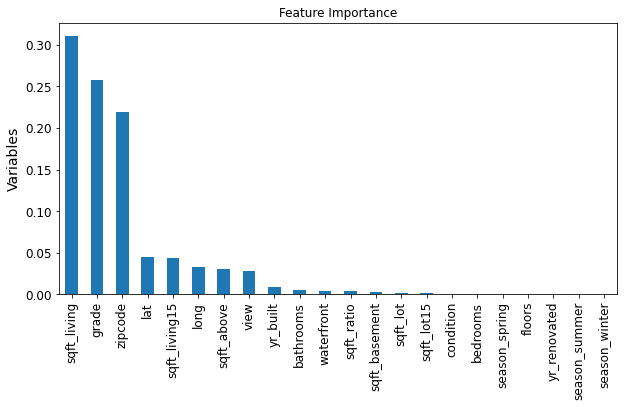

In [49]:
feature_importance = pd.Series(np.abs(rf_model.feature_importances_))
feature_importance.index = TRAIN_VARS
feature_importance.sort_values(inplace=True,ascending=False)
feature_importance.plot.bar(figsize=(10,5))
plt.ylabel('Variables')
plt.title('Feature Importance')

### <font color=blue> 5.7. Cross Validation

In [50]:
# Cross Validation
cv_scores = cross_val_score(rf_model,X_train,y_train,scoring='r2',cv=10)
rmse = np.sqrt(-cross_val_score(rf_model,X_train, y_train,scoring="neg_mean_squared_error", cv =10))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ',np.round(np.mean(rmse),2))

R2 score:  [0.7977311  0.74543416 0.83853178 0.8206618  0.80123333 0.80286352
 0.82133764 0.85438521 0.82978809 0.82834395]
Average R2 score:  0.81
Average RMSE score:  160336.39


---
---
<a id="gradient_boosting"></a>
[content table](#content_table)
# <font color=red>6. Gradient Boosting Tree
    
### <font color=blue>6.1. Overview
1. **Idea**: Gradient Boosting works by sequentially adding predictors to an ensemble, the current model tries to correct the mistakes from the previous model. More specifically, the method tries to fit the new predictor to the residual errors/negative gradient made by the previous predictor, so each base model is fit on a modified version of the original dataset
    
    
2. **Algorithm**: Boosting tree works by fitting to residuals, not to the true label. So at each iteration, the original dataset is modified with y values is residual values computed from previous model
    
    + ***Initialize*** by setting F^(x) = 0 and r = y for all data points in the training set
    + ***Fit model F*** by minimizing the mean square error
    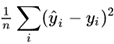
    
    + ***Repeat m=1,2,..,M***:
        + At each stage, 1 ≤ m ≤ M, of boosting, it may be assumed that there is some imperfect model Fm. The boosting algorithm improves on Fm by constructing a new model that adds an estimator h to provide a better model: 
                                    Fm+1(x) = Fm(x) + h(x)
    
        + To find h, the boosting solutions starts with the observation that a perfect h would imply
    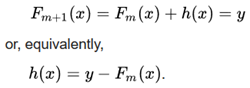
    
        + Therefore, boosting will fit h to the residual r = y – Fm(x)
    
    + ***Ouput the boosted model***
    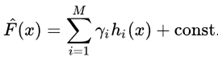

### <font color=blue>6.2. Train model with default parameters

In [51]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

gbt_model = GradientBoostingRegressor()
gbt_model.fit(X_train, y_train)

gbt_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [52]:
train_score = gbt_model.score(X_train, y_train)
test_score = gbt_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9106
Test R-squared: 0.8801


### <font color=blue> 6.3. Tuning model
    
+ **learning_rate**: scales the contribution of each tree. It you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is the regularization technique called shrinkage. If there are not enough trees to fit the training set it may cause underfitting, while if having has too many trees it may cause overfitting
+ **n_estimators**: 

#### Setting values of hyperparameters for searching 

In [53]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    # 'bootstrap': [True],
    'max_depth': [5, 8],
    'max_features': [8, 10],
    'min_samples_leaf': [30, 50],
    'min_samples_split': [100],
    'n_estimators': [300],
    'learning_rate': [0.3, 0.5]
}
# Create a based model
gbt_model = GradientBoostingRegressor()
# Instantiate the grid search model
gbt_grid_search = GridSearchCV(estimator = gbt_model, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2) 
# Fit the grid search to the data
gbt_grid_search.fit(X_train, y_train)  

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.7min finished


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 8], 'max_features': [8, 10],
                         'min_samples_leaf': [30, 50],
                         'min_samples_split': [100], 'n_estimators': [300]},
             verbose=2)

#### View the hyperparameters and detailed information for the model

In [54]:
# view best score
print('R-Squared::{}'.format(gbt_grid_search.best_score_))
# View best hyperparameters
print('Best hyperparameters::\n{}'.format(gbt_grid_search.best_params_))
# View detailed information of each iteration of GridSearchCV()
gridsearch_df = pd.DataFrame(gbt_grid_search.cv_results_)
gridsearch_df.head(5)

R-Squared::0.8893421741155196
Best hyperparameters::
{'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 300}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,10.852,2.574,0.020,0.003,5,8,30,100,300,"{'max_depth': 5, 'max_features': 8, 'min_sampl...",...,0.865,0.890,0.910,0.891,0.894,0.896,0.898,0.887,0.019,4
1,15.298,0.872,0.028,0.007,5,8,50,100,300,"{'max_depth': 5, 'max_features': 8, 'min_sampl...",...,0.874,0.892,0.906,0.894,0.899,0.897,0.897,0.889,0.017,1
2,20.621,1.985,0.027,0.004,5,10,30,100,300,"{'max_depth': 5, 'max_features': 10, 'min_samp...",...,0.871,0.889,0.904,0.893,0.893,0.894,0.896,0.888,0.015,2
3,21.654,1.232,0.030,0.004,5,10,50,100,300,"{'max_depth': 5, 'max_features': 10, 'min_samp...",...,0.867,0.884,0.902,0.897,0.900,0.893,0.898,0.885,0.019,7
4,29.391,1.525,0.046,0.007,8,8,30,100,300,"{'max_depth': 8, 'max_features': 8, 'min_sampl...",...,0.853,0.895,0.888,0.889,0.887,0.902,0.904,0.883,0.023,8


#### View grid search results

In [109]:
results = grid_search.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300} 0.8092 0.0007
{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300} 0.8045 0.0021
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300} 0.8045 0.0014
{'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 300} 0.7938 0.002


#### Train model with the best paramters

In [55]:
gbt_model = gbt_grid_search.best_estimator_
gbt_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, max_features=8, min_samples_leaf=50,
                          min_samples_split=100, n_estimators=300)

### <font color=blue>6.4. Prediction

In [56]:
pred_train = gbt_model.predict(X_train)
print('Train prediction: ',list(pred_train[0:5]))
print('Train true label: ',list(y_train[0:5]))
print()
pred_test = gbt_model.predict(X_test)
print('Test prediction: ',list(pred_test[0:5]))
print('Test true label: ',list(y_test[0:5]))
print()
print('Average house price: ', y_train.median())

Train prediction:  [530767.0234875963, 570322.9783169884, 425867.2746870056, 339173.610797491, 594420.7145795514]
Train true label:  [495000.0, 635000.0, 382500.0, 382500.0, 670000.0]

Test prediction:  [301866.79412573273, 1794921.7781348634, 519673.2895285884, 611881.8307610955, 697141.7558860951]
Test true label:  [297000.0, 1578000.0, 562100.0, 631500.0, 780000.0]

Average house price:  453000.0


### <font color=blue> 6.5. Model Evaluation

#### R-squared

In [57]:
train_score = gbt_model.score(X_train, y_train)
test_score = gbt_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9362
Test R-squared: 0.9086


#### MSE, RMSE

In [58]:
print('linear train mse: {}'.format(mean_squared_error(y_train, pred_train)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print()
print('linear test mse: {}'.format(mean_squared_error(y_test,pred_test)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

linear train mse: 8849653527.030592
linear train rmse: 94072.59711005428

linear test mse: 10864957543.972862
linear test rmse: 104235.10706078284


#### Residual plot

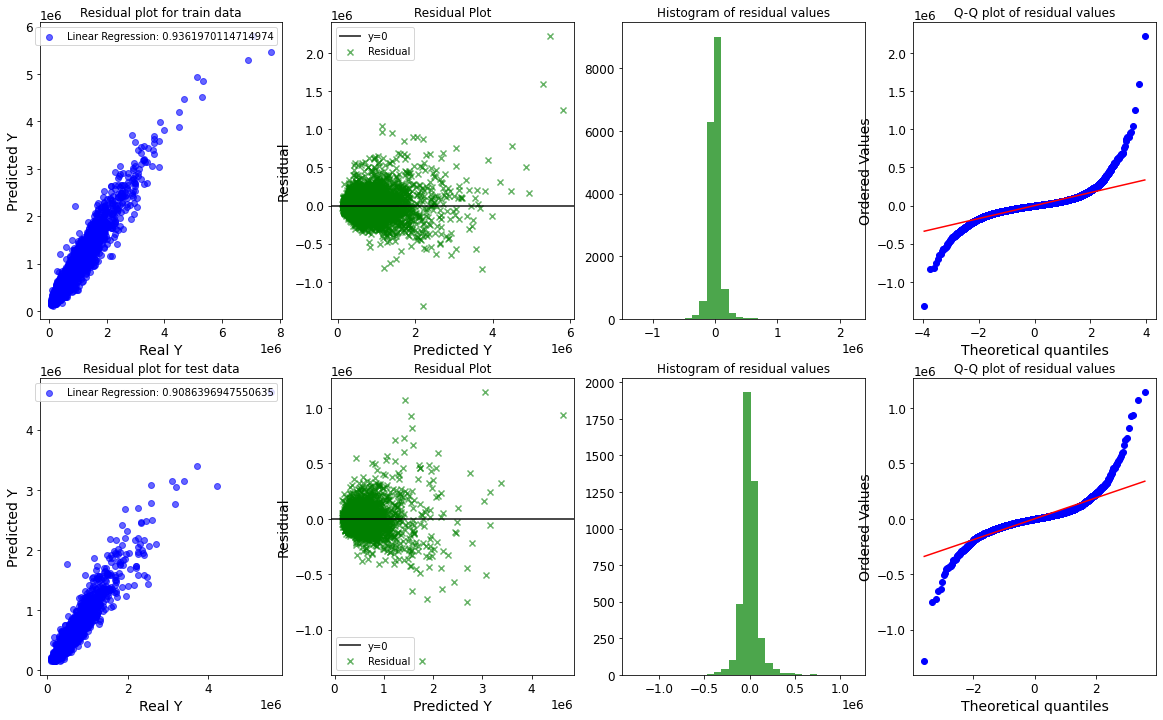

In [59]:
fig, axes = plt.subplots(2,4,figsize=(20,12))
plot_residual(axes[0][0],axes[0][1],axes[0][2],axes[0][3],pred_train,y_train,'Linear Regression: {}'.format(train_score),'Residual plot for train data')
plot_residual(axes[1][0],axes[1][1],axes[1][2],axes[1][3],pred_test,y_test,'Linear Regression: {}'.format(test_score),'Residual plot for test data')
fig.show()

### <font color=blue> 6.6. Feature Importance 

Text(0.5, 1.0, 'Feature Importance')

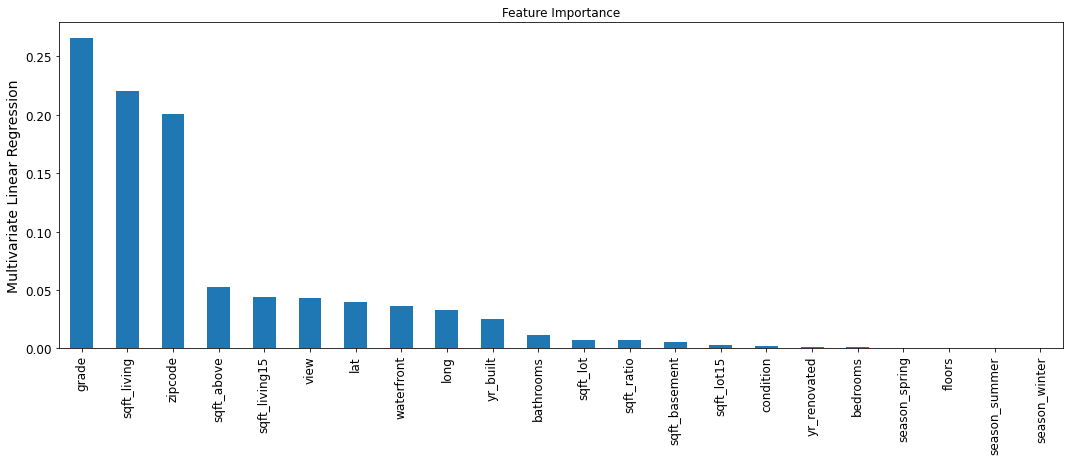

In [60]:
feature_importance = pd.Series(np.abs(gbt_model.feature_importances_))
feature_importance.index = TRAIN_VARS
feature_importance.sort_values(inplace=True,ascending=False)
feature_importance.plot.bar(figsize=(18,6))
plt.ylabel('Multivariate Linear Regression')
plt.title('Feature Importance')

### <font color=blue> 6.7. Cross Validation

In [61]:
# Cross Validation
cv_scores = cross_val_score(gbt_model,X_train,y_train,scoring='r2',cv=10)
rmse = np.sqrt(-cross_val_score(gbt_model,X_train, y_train,scoring="neg_mean_squared_error", cv =10))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ',np.round(np.mean(rmse),2))

R2 score:  [0.89308216 0.84230861 0.89326696 0.86038051 0.8883125  0.9073898
 0.89460565 0.89850824 0.90099901 0.89581316]
Average R2 score:  0.89
Average RMSE score:  124272.79


### <font color=blue> 6.8. Gradient Boosting with Early stopping

In [111]:
gbrt = GradientBoostingRegressor(max_depth=5, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(400, 450):
    print(n_estimators)
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422


In [112]:
print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

422
Minimum validation MSE: 10583003017.14202


In [113]:
gbt_grid_search.best_estimator_

GradientBoostingRegressor(max_depth=5, max_features=8, min_samples_leaf=50,
                          min_samples_split=100, n_estimators=300)

In [114]:
gbt_model = GradientBoostingRegressor(max_depth=5, max_features=8, min_samples_leaf=50,
                          min_samples_split=100, n_estimators=422)
gbt_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, max_features=8, min_samples_leaf=50,
                          min_samples_split=100, n_estimators=422)

In [115]:
train_score = gbt_model.score(X_train, y_train)
test_score = gbt_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9460
Test R-squared: 0.9130


In [166]:
# Cross Validation
cv_scores = cross_val_score(gbt_model,X_train,y_train,scoring='r2',cv=10)
rmse = np.sqrt(-cross_val_score(gbt_model,X_train, y_train,scoring="neg_mean_squared_error", cv =10))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ',np.round(np.mean(rmse),2))

R2 score:  [0.8955156  0.84862461 0.88965406 0.86628402 0.89089816 0.9087485
 0.89316009 0.90410869 0.90437358 0.90177122]
Average R2 score:  0.89
Average RMSE score:  122716.46


---
---
<a id="xgb"></a>
[content table](#content_table)
# <font color=red>7. XGBoost
    
### <font color=blue> 7.1.  Introduction

### <font color=blue> 7.2. Train model

In [99]:
import xgboost

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [100]:
train_score = xgb_model.score(X_train, y_train)
test_score = xgb_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9772
Test R-squared: 0.9052


### <font color=blue> 7.3.  Tuning model

#### Setting values of hyperparameters for searching 

In [101]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    # 'bootstrap': [True],
    'max_depth': [5, 8],
    'max_features': [8, 10],
    'min_samples_leaf': [20, 50],
    'min_samples_split': [100, 200],
    'n_estimators': [300]
}
# Create a based model
xgb_model = GradientBoostingRegressor()
# Instantiate the grid search model
xgb_grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2) 
# Fit the grid search to the data
xgb_grid_search.fit(X_train, y_train)  

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 14.8min finished


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 8], 'max_features': [8, 10],
                         'min_samples_leaf': [20, 50],
                         'min_samples_split': [100, 200],
                         'n_estimators': [300]},
             verbose=2)

#### View the hyperparameters and detailed information for the model

In [102]:
# view best score
print('R-Squared:{}'.format(xgb_grid_search.best_score_))
# View best hyperparameters
print('Best hyperparameters:\n{}'.format(xgb_grid_search.best_params_))
# View detailed information of each iteration of GridSearchCV()
gridsearch_df = pd.DataFrame(xgb_grid_search.cv_results_)
gridsearch_df.head(5)

R-Squared:0.8888944893046744
Best hyperparameters:
{'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 300}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,21.068,1.455,0.033,0.004,5,8,20,100,300,"{'max_depth': 5, 'max_features': 8, 'min_sampl...",...,0.870,0.891,0.913,0.882,0.894,0.902,0.901,0.889,0.019,2
1,23.182,2.013,0.039,0.008,5,8,20,200,300,"{'max_depth': 5, 'max_features': 8, 'min_sampl...",...,0.868,0.889,0.909,0.883,0.877,0.893,0.902,0.884,0.017,9
2,26.452,2.303,0.044,0.006,5,8,50,100,300,"{'max_depth': 5, 'max_features': 8, 'min_sampl...",...,0.867,0.889,0.908,0.898,0.904,0.900,0.897,0.888,0.018,3
3,28.334,2.224,0.043,0.007,5,8,50,200,300,"{'max_depth': 5, 'max_features': 8, 'min_sampl...",...,0.863,0.883,0.898,0.889,0.898,0.882,0.898,0.882,0.017,14
4,37.240,2.677,0.053,0.013,5,10,20,100,300,"{'max_depth': 5, 'max_features': 10, 'min_samp...",...,0.864,0.884,0.908,0.883,0.890,0.897,0.899,0.886,0.016,5


#### Train model with the best paramters

In [103]:
xgb_model = xgb_grid_search.best_estimator_
xgb_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=8, max_features=8, min_samples_leaf=50,
                          min_samples_split=100, n_estimators=300)

### <font color=blue> 7.4. Prediction

In [104]:
pred_train = xgb_model.predict(X_train)
print('Train prediction: ',list(pred_train[0:5]))
print('Train true label: ',list(y_train[0:5]))
print()
pred_test = xgb_model.predict(X_test)
print('Test prediction: ',list(pred_test[0:5]))
print('Test true label: ',list(y_test[0:5]))
print()
print('Average house price: ', y_train.median())

Train prediction:  [509702.10656020744, 551542.7032459386, 407579.438280551, 331432.1707152316, 642767.7161280651]
Train true label:  [495000.0, 635000.0, 382500.0, 382500.0, 670000.0]

Test prediction:  [289726.92955904437, 1715149.3669816346, 526799.3846510858, 619868.9768052695, 719144.9978000642]
Test true label:  [297000.0, 1578000.0, 562100.0, 631500.0, 780000.0]

Average house price:  453000.0


### <font color=blue> 7.5. Model Evaluation

#### R-squared

In [105]:
train_score = xgb_model.score(X_train, y_train)
test_score = xgb_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9514
Test R-squared: 0.9068


#### MSE, RMSE

In [106]:
print('linear train mse: {}'.format(mean_squared_error(y_train, pred_train)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print()
print('linear test mse: {}'.format(mean_squared_error(y_test,pred_test)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

linear train mse: 6744264607.831085
linear train rmse: 82123.47172295558

linear test mse: 11085803136.8541
linear test rmse: 105289.14064068573


#### Residual plot

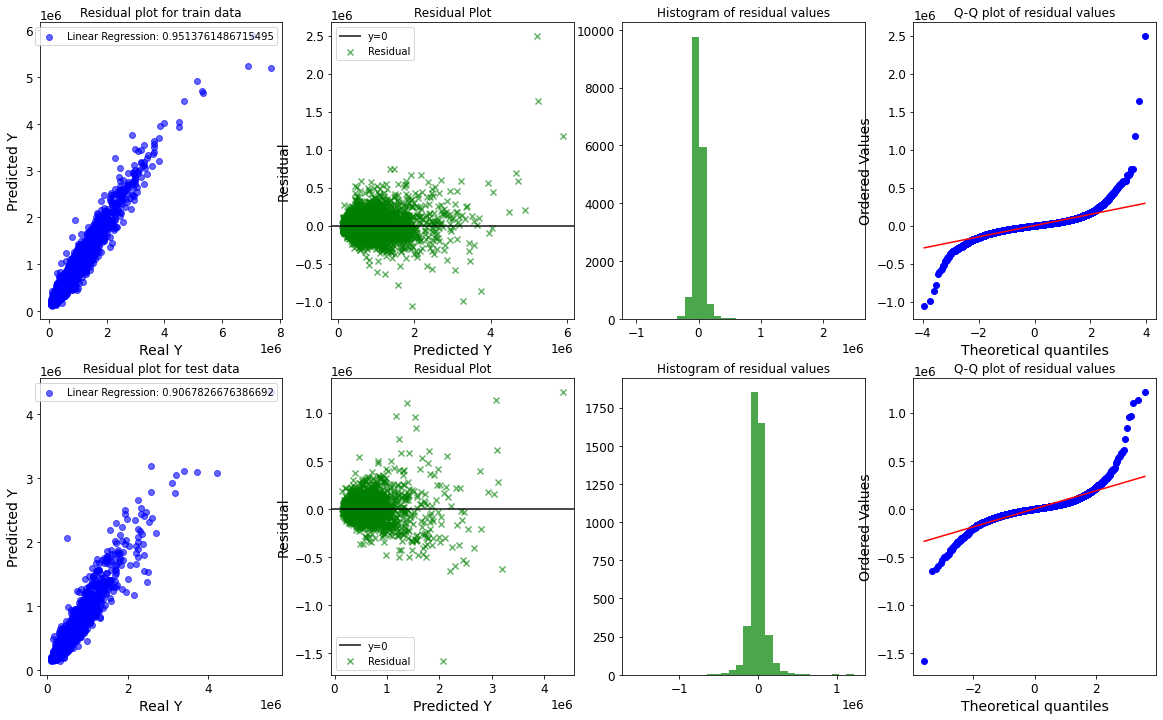

In [107]:
fig, axes = plt.subplots(2,4,figsize=(20,12))
plot_residual(axes[0][0],axes[0][1],axes[0][2],axes[0][3],pred_train,y_train,'Linear Regression: {}'.format(train_score),'Residual plot for train data')
plot_residual(axes[1][0],axes[1][1],axes[1][2],axes[1][3],pred_test,y_test,'Linear Regression: {}'.format(test_score),'Residual plot for test data')
fig.show()

### <font color=blue> 7.6. Feature Importance 

Text(0.5, 1.0, 'Feature Importance')

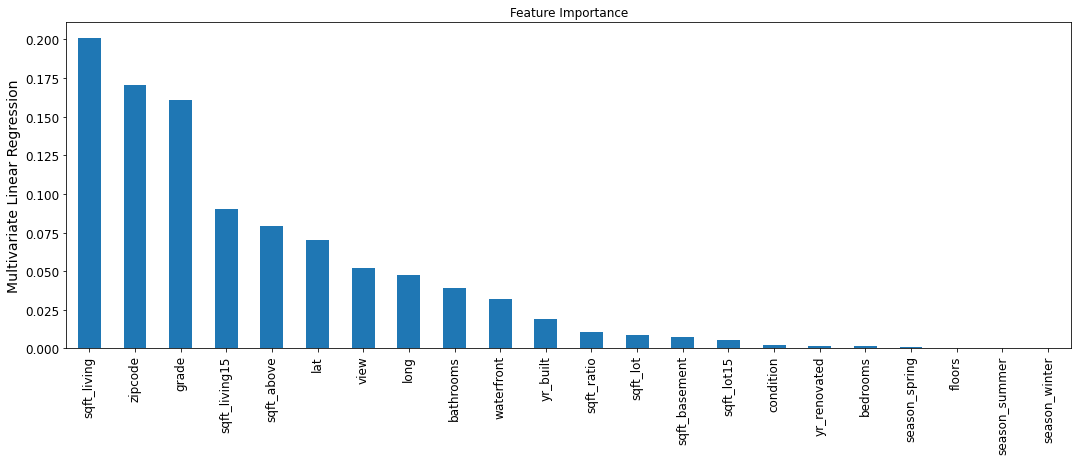

In [108]:
feature_importance = pd.Series(np.abs(xgb_model.feature_importances_))
feature_importance.index = TRAIN_VARS
feature_importance.sort_values(inplace=True, ascending=False)
feature_importance.plot.bar(figsize=(18,6))
plt.ylabel('Multivariate Linear Regression')
plt.title('Feature Importance')

### <font color=blue> 7.7. Cross Validation

In [109]:
# Cross Validation
cv_scores = cross_val_score(xgb_model,X_train,y_train,scoring='r2',cv=10)
rmse = np.sqrt(-cross_val_score(xgb_model,X_train, y_train,scoring="neg_mean_squared_error", cv =10))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ',np.round(np.mean(rmse),2))

R2 score:  [0.88450973 0.83864158 0.89888236 0.86723657 0.89256491 0.90329715
 0.88932043 0.90536798 0.89967178 0.9025844 ]
Average R2 score:  0.89
Average RMSE score:  123831.63


---
---
<a id="dnn"></a>
[content table](#content_table)
# <font color=red>8. ANN/DNN
  
### <font color=blue> 8.1.  Introduction

### <font color=blue>  8.2. Import library

In [78]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

In [79]:
def plot_history(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### <font color=blue> 8.3. Construct architecture

### <font color=green> 1 hidden layer

In [81]:
def dnn_model1(dim1,n_epochs, batch_size):   
    keras.backend.clear_session()
    tf.keras.backend.clear_session
    tf.random.set_seed(9)
    np.random.seed(9)
    
    dnn = Sequential()
    dnn.add(Dense(dim1, input_dim=len(TRAIN_VARS), activation='relu'))
    dnn.add(Dense(1, activation='relu'))
    print(dnn.summary())
    
    dnn.compile(loss='mse', optimizer='adam', metrics=['mae'])
    t_ini = datetime.datetime.now()
    history = dnn.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,  verbose=1, validation_split=0.2)
    t_fin = datetime.datetime.now()
    print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))
    plot_history(history)
    performance_evaluation(X_train, X_test, y_train, y_test, dnn)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                460       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1384/1384 [==============================] - 5s 3ms/step - loss: 439691608064.0000 - mae: 544716.7500 - val_loss: 407014998016.0000 - val_mae: 534361.8750
Epoch 2/30
1384/1384 [==============================] - 3s 3ms/step - loss: 439000596480.0000 - mae: 544127.7500 - val_loss: 406075736064.0000 - val_mae: 533543.0000
Epoch 3/30
1384/1384 [==============================] - 4s 3ms/step - loss: 437787721728.0000 - mae: 543094.3750 - val_loss: 404650426368.0000 - val_mae: 532298.8750
Epoch 4/30
1384/1

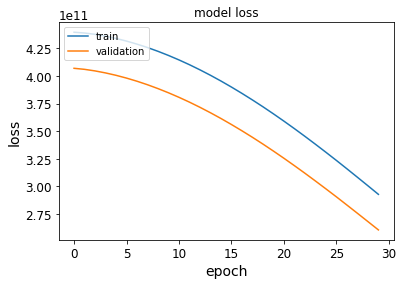

Train mse: 283209840254.5048
Train rmse: 532174.6332309581

Test mse: 254363348328.12387
Test rmse: 504344.4738748744


In [89]:
dnn_model1(20, n_epochs=30, batch_size=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2300      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
433/433 [==============================] - 1s 2ms/step - loss: 439759208448.0000 - mae: 544774.9375 - val_loss: 407198072832.0000 - val_mae: 534521.4375
Epoch 2/30
433/433 [==============================] - 1s 2ms/step - loss: 439364255744.0000 - mae: 544439.2500 - val_loss: 406612770816.0000 - val_mae: 534012.9375
Epoch 3/30
433/433 [==============================] - 1s 2ms/step - loss: 438579200000.0000 - mae: 543773.0000 - val_loss: 405678358528.0000 - val_mae: 533200.3125
Epoch 4/30
433/433 

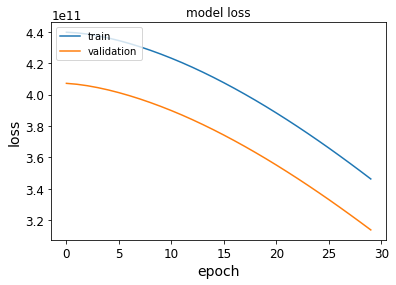

Train mse: 337726540697.3948
Train rmse: 581142.4444122068

Test mse: 306887358638.53357
Test rmse: 553974.1497926898


In [83]:
dnn_model1(100, n_epochs=30, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               4600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1384/1384 [==============================] - 4s 3ms/step - loss: 438655156224.0000 - mae: 543823.5000 - val_loss: 404011646976.0000 - val_mae: 531739.6250
Epoch 2/30
1384/1384 [==============================] - 4s 3ms/step - loss: 432273850368.0000 - mae: 538354.1250 - val_loss: 395322916864.0000 - val_mae: 524084.9062
Epoch 3/30
1384/1384 [==============================] - 4s 3ms/step - loss: 421402509312.0000 - mae: 528922.4375 - val_loss: 382984388608.0000 - val_mae: 513028.2188
Epoch 4/30
13

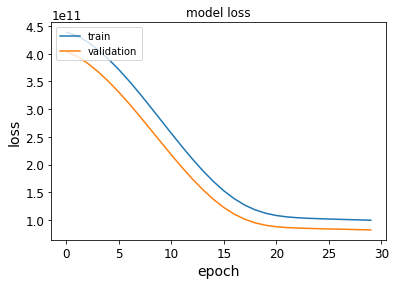

Train mse: 96077425738.8915
Train rmse: 309963.58776296856

Test mse: 80380489511.82726
Test rmse: 283514.53139447235


In [88]:
dnn_model1(200, n_epochs=30, batch_size=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2300      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1384/1384 [==============================] - 3s 2ms/step - loss: 439232200704.0000 - mae: 544320.5625 - val_loss: 405672525824.0000 - val_mae: 533190.6875
Epoch 2/30
1384/1384 [==============================] - 3s 2ms/step - loss: 435963002880.0000 - mae: 541528.6250 - val_loss: 401203265536.0000 - val_mae: 529276.1250
Epoch 3/30
1384/1384 [==============================] - 3s 2ms/step - loss: 430347616256.0000 - mae: 536704.1250 - val_loss: 394791845888.0000 - val_mae: 523612.6250
Epoch 4/30
13

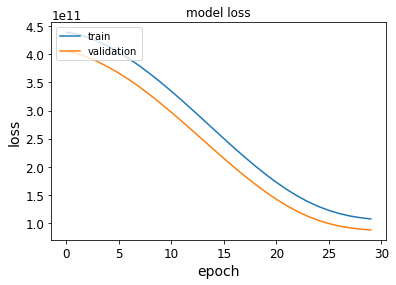

Train mse: 102591174903.08507
Train rmse: 320298.57149710343

Test mse: 85255995817.8268
Test rmse: 291986.29388693365


In [84]:
dnn_model1(100, n_epochs=30, batch_size=10)

### <font color=green> 2 hidden layers

In [90]:
def dnn_model2(dim1,n_epochs, batch_size):   
    keras.backend.clear_session()
    tf.keras.backend.clear_session
    tf.random.set_seed(9)
    np.random.seed(9)
    
    dnn = Sequential()
    dnn.add(Dense(dim1, input_dim=len(TRAIN_VARS), activation='relu'))
    dnn.add(Dense(50, activation='relu'))
    dnn.add(Dense(1, activation='relu'))
    print(dnn.summary())
    
    dnn.compile(loss='mse', optimizer='adam', metrics=['mae'])
    t_ini = datetime.datetime.now()
    history = dnn.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,  verbose=1, validation_split=0.2)
    t_fin = datetime.datetime.now()
    print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))
    plot_history(history)
    performance_evaluation(X_train, X_test, y_train, y_test, dnn)

#### Select number of neurons in the first hidden layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                575       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,926
Trainable params: 1,926
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
433/433 [==============================] - 3s 4ms/step - loss: 439395680256.0000 - mae: 544460.7500 - val_loss: 405535293440.0000 - val_mae: 533074.8125
Epoch 2/50
433/433 [==============================] - 1s 3ms/step - loss: 432159621120.0000 - mae: 538256.7500 - val_loss: 391326728192.0000 - val_mae: 520564.7812
Epoch 3/50
433/433 [==============================]

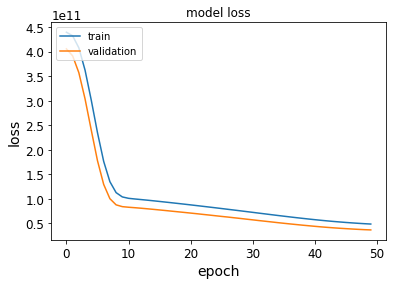

Train mse: 46221873364.53981
Train rmse: 214992.72863178374

Test mse: 38767779397.943565
Test rmse: 196895.35138733865


In [92]:
dnn_model2(25, n_epochs=50, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1150      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,751
Trainable params: 3,751
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
433/433 [==============================] - 2s 3ms/step - loss: 438629990400.0000 - mae: 543797.6875 - val_loss: 402352537600.0000 - val_mae: 530292.0625
Epoch 2/50
433/433 [==============================] - 1s 3ms/step - loss: 420326834176.0000 - mae: 527903.2500 - val_loss: 367675211776.0000 - val_mae: 499061.5938
Epoch 3/50
433/433 [==============================]

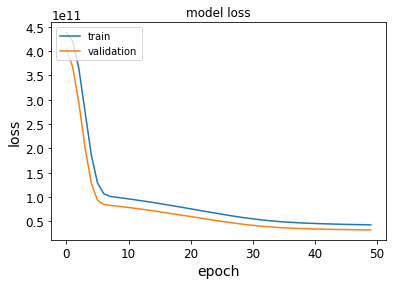

Train mse: 40626487255.6523
Train rmse: 201560.13310089943

Test mse: 34931166920.935486
Test rmse: 186898.81465898998


In [91]:
dnn_model2(50, n_epochs=50, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               4600      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
433/433 [==============================] - 2s 4ms/step - loss: 436071530496.0000 - mae: 541576.1875 - val_loss: 391742259200.0000 - val_mae: 520936.5312
Epoch 2/50
433/433 [==============================] - 1s 3ms/step - loss: 381991485440.0000 - mae: 492571.6875 - val_loss: 294503940096.0000 - val_mae: 426196.7188
Epoch 3/50
433/433 [=============================

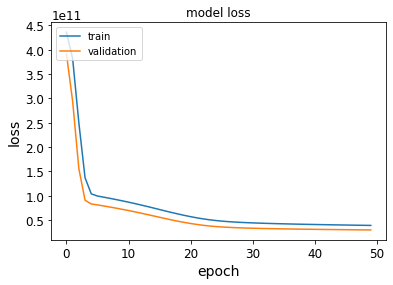

Train mse: 37201315816.78309
Train rmse: 192876.42628580375

Test mse: 32225179663.048008
Test rmse: 179513.73112675257


In [93]:
dnn_model2(200, n_epochs=50, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               4600      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
433/433 [==============================] - 2s 3ms/step - loss: 436071530496.0000 - mae: 541576.1875 - val_loss: 391742259200.0000 - val_mae: 520936.5312
Epoch 2/200
433/433 [==============================] - 1s 3ms/step - loss: 381991485440.0000 - mae: 492571.6875 - val_loss: 294503940096.0000 - val_mae: 426196.7188
Epoch 3/200
433/433 [==========================

433/433 [==============================] - 1s 3ms/step - loss: 34309298176.0000 - mae: 108108.6719 - val_loss: 26448758784.0000 - val_mae: 101898.5859
Epoch 97/200
433/433 [==============================] - 1s 3ms/step - loss: 34209042432.0000 - mae: 108204.1797 - val_loss: 26394468352.0000 - val_mae: 101530.4922
Epoch 98/200
433/433 [==============================] - 1s 2ms/step - loss: 34135320576.0000 - mae: 107905.0469 - val_loss: 26340368384.0000 - val_mae: 101373.5781
Epoch 99/200
433/433 [==============================] - 1s 3ms/step - loss: 34051211264.0000 - mae: 107907.9766 - val_loss: 26289164288.0000 - val_mae: 101341.3359
Epoch 100/200
433/433 [==============================] - 2s 4ms/step - loss: 33999642624.0000 - mae: 107647.5469 - val_loss: 26234556416.0000 - val_mae: 101450.0234
Epoch 101/200
433/433 [==============================] - 1s 3ms/step - loss: 33924012032.0000 - mae: 107685.5234 - val_loss: 26191353856.0000 - val_mae: 101100.8828
Epoch 102/200
433/433 [====

Epoch 146/200
433/433 [==============================] - 1s 3ms/step - loss: 31046111232.0000 - mae: 102421.0156 - val_loss: 24017797120.0000 - val_mae: 96391.2812
Epoch 147/200
433/433 [==============================] - 1s 3ms/step - loss: 30989332480.0000 - mae: 102255.8906 - val_loss: 23974301696.0000 - val_mae: 96360.3750
Epoch 148/200
433/433 [==============================] - 1s 3ms/step - loss: 30929563648.0000 - mae: 102189.1953 - val_loss: 23938058240.0000 - val_mae: 96417.2031
Epoch 149/200
433/433 [==============================] - 1s 3ms/step - loss: 30849069056.0000 - mae: 102151.7734 - val_loss: 23881736192.0000 - val_mae: 95913.3203
Epoch 150/200
433/433 [==============================] - 1s 2ms/step - loss: 30783780864.0000 - mae: 101972.6562 - val_loss: 23833509888.0000 - val_mae: 95761.4609
Epoch 151/200
433/433 [==============================] - 1s 3ms/step - loss: 30711392256.0000 - mae: 101914.5469 - val_loss: 23783507968.0000 - val_mae: 95747.1641
Epoch 152/200
43

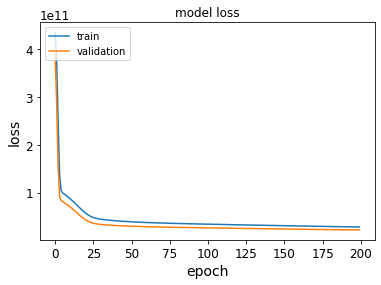

Train mse: 26818216615.316338
Train rmse: 163762.68383034132

Test mse: 23438803961.645405
Test rmse: 153097.3675856166


In [95]:
dnn_model2(200, n_epochs=200, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               5750      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12550     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 18,351
Trainable params: 18,351
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
433/433 [==============================] - 2s 3ms/step - loss: 434593595392.0000 - mae: 540279.6875 - val_loss: 385582268416.0000 - val_mae: 515421.3438
Epoch 2/300
433/433 [==============================] - 1s 3ms/step - loss: 361479897088.0000 - mae: 472315.6250 - val_loss: 258692268032.0000 - val_mae: 385854.2500
Epoch 3/300
433/433 [==========================

433/433 [==============================] - 1s 3ms/step - loss: 29656127488.0000 - mae: 98408.1562 - val_loss: 22929551360.0000 - val_mae: 92778.8438
Epoch 97/300
433/433 [==============================] - 1s 3ms/step - loss: 29519448064.0000 - mae: 98439.2031 - val_loss: 22869018624.0000 - val_mae: 92430.9375
Epoch 98/300
433/433 [==============================] - 1s 3ms/step - loss: 29405632512.0000 - mae: 98056.2656 - val_loss: 22797721600.0000 - val_mae: 92341.4844
Epoch 99/300
433/433 [==============================] - 1s 3ms/step - loss: 29289435136.0000 - mae: 98109.3750 - val_loss: 22732955648.0000 - val_mae: 92222.7656
Epoch 100/300
433/433 [==============================] - 1s 3ms/step - loss: 29196969984.0000 - mae: 97799.3047 - val_loss: 22646245376.0000 - val_mae: 92264.4922
Epoch 101/300
433/433 [==============================] - 1s 3ms/step - loss: 29085773824.0000 - mae: 97727.6562 - val_loss: 22586329088.0000 - val_mae: 91960.2422
Epoch 102/300
433/433 [================

433/433 [==============================] - 1s 3ms/step - loss: 23735048192.0000 - mae: 88559.9062 - val_loss: 19677130752.0000 - val_mae: 85212.1875
Epoch 197/300
433/433 [==============================] - 1s 3ms/step - loss: 23711666176.0000 - mae: 88579.5234 - val_loss: 19701665792.0000 - val_mae: 84775.8906
Epoch 198/300
433/433 [==============================] - 1s 3ms/step - loss: 23659231232.0000 - mae: 88381.3438 - val_loss: 19651160064.0000 - val_mae: 85065.6406
Epoch 199/300
433/433 [==============================] - 1s 3ms/step - loss: 23655294976.0000 - mae: 88389.2109 - val_loss: 19645362176.0000 - val_mae: 85318.2734
Epoch 200/300
433/433 [==============================] - 1s 3ms/step - loss: 23632418816.0000 - mae: 88461.7422 - val_loss: 19627311104.0000 - val_mae: 84994.3594
Epoch 201/300
433/433 [==============================] - 1s 3ms/step - loss: 23596251136.0000 - mae: 88291.4297 - val_loss: 19631333376.0000 - val_mae: 85405.5078
Epoch 202/300
433/433 [=============

433/433 [==============================] - 1s 3ms/step - loss: 21615935488.0000 - mae: 85286.9766 - val_loss: 18979956736.0000 - val_mae: 82477.6953
Epoch 297/300
433/433 [==============================] - 2s 4ms/step - loss: 21592193024.0000 - mae: 85265.3125 - val_loss: 18972657664.0000 - val_mae: 82550.0312
Epoch 298/300
433/433 [==============================] - 1s 3ms/step - loss: 21578256384.0000 - mae: 85303.8047 - val_loss: 19013513216.0000 - val_mae: 82231.1562
Epoch 299/300
433/433 [==============================] - 1s 3ms/step - loss: 21575323648.0000 - mae: 85214.9297 - val_loss: 18966028288.0000 - val_mae: 82741.2344
Epoch 300/300
433/433 [==============================] - 1s 3ms/step - loss: 21548351488.0000 - mae: 85238.2891 - val_loss: 18960934912.0000 - val_mae: 82537.1094
Time to run the model: 421.788811 Sec.
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


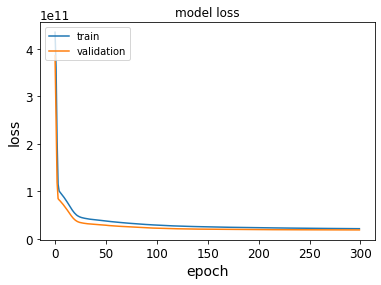

Train mse: 20983327183.33134
Train rmse: 144856.2293563219

Test mse: 18127180098.74596
Test rmse: 134637.21661838514


In [97]:
dnn_model2(250, n_epochs=300, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6900      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 22,001
Trainable params: 22,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
433/433 [==============================] - 2s 4ms/step - loss: 439821828096.0000 - mae: 544829.2500 - val_loss: 407385276416.0000 - val_mae: 534684.2500
Epoch 2/30
433/433 [==============================] - 1s 3ms/step - loss: 439821828096.0000 - mae: 544828.9375 - val_loss: 407385276416.0000 - val_mae: 534684.2500
Epoch 3/30
433/433 [=============================

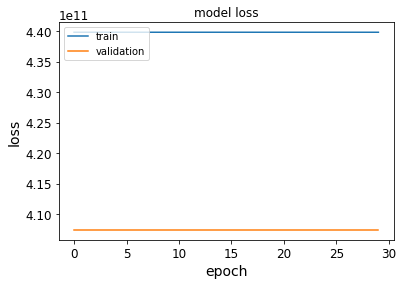

Train mse: 433334469675.75
Train rmse: 658281.4517178424

Test mse: 399022011977.41223
Test rmse: 631681.8914433215


In [98]:
dnn_model2(300, n_epochs=30, batch_size=0)

In [ ]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )